In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import LabelEncoder

In [2]:
import codecs
BLOCKSIZE = 1048576 # or some other, desired size in bytes
with codecs.open('data.csv', "r") as sourceFile:
    with codecs.open('project2_data.csv', "w", "utf-8") as targetFile:
        while True:
            contents = sourceFile.read(BLOCKSIZE)
            if not contents:
                break
            targetFile.write(contents)

In [3]:
df = pd.read_csv('project2_data.csv')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Data Overview

In [4]:
print(f' Size of the dataset: \n Number of Rows :{df.shape[0]} \n Number of Columns :{df.shape[1]}')

 Size of the dataset: 
 Number of Rows :541909 
 Number of Columns :8


### Data Description
###### InvoiceNo: A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation. 
###### StockCode: Product code. A 5-digit integer number uniquely assigned to each distinct product. 
###### Description: Product name.
###### Quantity: The quantities of each product per transaction. Numeric. 
###### InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated. 
###### UnitPrice: Numeric, Product price per unit. 
###### CustomerID: A 5-digit integral number uniquely assigned to each customer. 
###### Country: The name of the country where each customer resides

In [5]:
#Data set Time Period
min_date = pd.to_datetime(df['InvoiceDate'].min())
max_date = pd.to_datetime(df['InvoiceDate'].max())
print(f'Data set time period is {min_date} to {max_date}')
print(f'Number of days: {(max_date-min_date).days}')

Data set time period is 2011-01-10 10:04:00 to 2011-09-09 09:52:00
Number of days: 241


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
#6 Payment Analysis - Genrating dummy Data to do payment analysis
payment_methods = ['Credit Card', 'Debit Card', 'PayPal', 'Bank Transfer', 'Cash', 'EMI']
probabilities = [0.4, 0.2, 0.15, 0.05, 0.17, 0.03]
df['PaymentMethod'] = np.random.choice(payment_methods, size=len(df), p=probabilities)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PaymentMethod
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Credit Card
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Debit Card
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Debit Card
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,PayPal
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Debit Card


In [8]:
df.drop_duplicates(inplace = True)

In [9]:
df.isnull().sum()

InvoiceNo             0
StockCode             0
Description        1454
Quantity              0
InvoiceDate           0
UnitPrice             0
CustomerID       135069
Country               0
PaymentMethod         0
dtype: int64

In [10]:
df['Date'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [11]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,540480.0,9.569993,-80995.0,1.0,3.0,10.0,80995.0,218.352095
UnitPrice,540480.0,4.6171,-11062.06,1.25,2.08,4.13,38970.0,96.887551
CustomerID,405411.0,15285.930357,12346.0,13952.0,15150.0,16791.0,18287.0,1713.754802
Date,540480,2011-07-04 12:16:26.137433344,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 15:55:00,2011-10-19 10:48:00,2011-12-09 12:50:00,NaN
Year,540480.0,2010.92164,2010.0,2011.0,2011.0,2011.0,2011.0,0.268737
Month,540480.0,7.550951,1.0,5.0,8.0,11.0,12.0,3.509016
Day,540480.0,15.023566,1.0,7.0,15.0,22.0,31.0,8.663989


In [12]:
df.dropna(how = 'all',inplace = True)
df.shape

(540480, 13)

In [13]:
#Create another column called staus .If invoice ID starts with c that means the order is cancelled
for index, row in df.iterrows():
    if row['InvoiceNo'].startswith(('c', 'C')):
        df.at[index, 'status'] = 'Cancelled'
    else:
        df.at[index, 'status'] = 'Placed'

C:\Users\rushi\AppData\Local\Temp\ipykernel_22228\1190226568.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Placed' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'status'] = 'Placed'


In [14]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PaymentMethod,Date,Year,Month,Day,status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Credit Card,2010-12-01 08:26:00,2010,12,1,Placed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Debit Card,2010-12-01 08:26:00,2010,12,1,Placed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Debit Card,2010-12-01 08:26:00,2010,12,1,Placed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,PayPal,2010-12-01 08:26:00,2010,12,1,Placed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Debit Card,2010-12-01 08:26:00,2010,12,1,Placed


In [15]:
print(f'Number of unique Customer IDs: {len(df["CustomerID"].unique())}')

Number of unique Customer IDs: 4373


In [16]:
#Updating description null values 
def get_mode(x):
    mode = x.mode()
    return mode.iloc[0] if not mode.empty else None 

# Making a dictionary of grouped StockCode and Corresponding Description
replacement_dict = df.groupby('StockCode')['Description'].apply(get_mode).to_dict()

# Replaced Missing values with the corresponding mode value
df['Description'] = df.apply(lambda row: replacement_dict.get(row['StockCode'],row['Description']),axis=1)

In [17]:
df.isnull().sum()

InvoiceNo             0
StockCode             0
Description         112
Quantity              0
InvoiceDate           0
UnitPrice             0
CustomerID       135069
Country               0
PaymentMethod         0
Date                  0
Year                  0
Month                 0
Day                   0
status                0
dtype: int64

In [18]:
# Removing rows with unit price 0
df = df[(df["UnitPrice"]!=0)]

In [19]:
# Removing rows with Quantity 0
df = df[(df["Quantity"]!=0)]

In [20]:
df['Description'].fillna('Description not available',inplace = True)

In [21]:
# removing unnecessary values from description (values that are not a product)
#df = df[~(df["Description"].str.islower())]
df.shape

(537967, 14)

In [22]:
for x in df.columns:
    print(x,":", df[x].dtype)

InvoiceNo : object
StockCode : object
Description : object
Quantity : int64
InvoiceDate : object
UnitPrice : float64
CustomerID : float64
Country : object
PaymentMethod : object
Date : datetime64[ns]
Year : int32
Month : int32
Day : int32
status : object


In [23]:
df.isnull().sum()

InvoiceNo             0
StockCode             0
Description           0
Quantity              0
InvoiceDate           0
UnitPrice             0
CustomerID       132596
Country               0
PaymentMethod         0
Date                  0
Year                  0
Month                 0
Day                   0
status                0
dtype: int64

In [24]:
df1 = df[~(df['CustomerID'].isnull())]

In [25]:
df1.shape

(405371, 14)

In [26]:
#Changing CustomerID datatype to int
df1['CustomerID'] = df1['CustomerID'].astype('int64')

C:\Users\rushi\AppData\Local\Temp\ipykernel_22228\3094069463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['CustomerID'] = df1['CustomerID'].astype('int64')


In [27]:
# Checking if there are any negative values for placed status
filtered_df = df1[(df1['status'] == 'Placed') & (df1['Quantity'] < 0)]
print(len(filtered_df))

0


In [28]:
# Stroring df1 in another dataframe for future use
df1_uf = df1

In [29]:
# Filtering df1 
df1 = df1[df1['status']=='Placed']
df1.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PaymentMethod,Date,Year,Month,Day,status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,Credit Card,2010-12-01 08:26:00,2010,12,1,Placed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,Debit Card,2010-12-01 08:26:00,2010,12,1,Placed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,Debit Card,2010-12-01 08:26:00,2010,12,1,Placed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,PayPal,2010-12-01 08:26:00,2010,12,1,Placed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,Debit Card,2010-12-01 08:26:00,2010,12,1,Placed


In [30]:
df1.isnull().sum()

InvoiceNo        0
StockCode        0
Description      0
Quantity         0
InvoiceDate      0
UnitPrice        0
CustomerID       0
Country          0
PaymentMethod    0
Date             0
Year             0
Month            0
Day              0
status           0
dtype: int64

In [31]:
for x in df1.columns:
    print(x,":", df1[x].dtype)

InvoiceNo : object
StockCode : object
Description : object
Quantity : int64
InvoiceDate : object
UnitPrice : float64
CustomerID : int64
Country : object
PaymentMethod : object
Date : datetime64[ns]
Year : int32
Month : int32
Day : int32
status : object


In [32]:
# Customer Analysis
#1
unique_customers = df['CustomerID'].nunique()
print(f'Number of unique customers: {unique_customers}')

Number of unique customers: 4371


In [33]:
#2
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].count()
orders_per_customer = orders_per_customer.reset_index()
orders_per_customer = orders_per_customer.rename(columns={'CustomerID': 'Customer ID', 'InvoiceNo': 'Count'})
print('Distribution of orders per customer:')
print(orders_per_customer['Count'].describe())

Distribution of orders per customer:
count    4371.000000
mean       92.741020
std       231.608068
min         1.000000
25%        17.000000
50%        42.000000
75%       101.000000
max      7943.000000
Name: Count, dtype: float64


In [34]:
#3
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].count()
orders_per_customer.index = orders_per_customer.index.astype('int64')
top_five_customers = orders_per_customer.sort_values(ascending=False).head(5)
top_five_customers = top_five_customers.reset_index()
top_five_customers = top_five_customers.rename(columns={'CustomerID': 'CustomerID', 'InvoiceNo': 'Count'})
top_five_customers = top_five_customers.set_index('CustomerID')
print(f"Top Five customers are:\n{top_five_customers}")

Top Five customers are:
            Count
CustomerID       
17841        7943
14911        5901
14096        5128
12748        4590
14606        2774


<Figure size 1000x600 with 0 Axes>

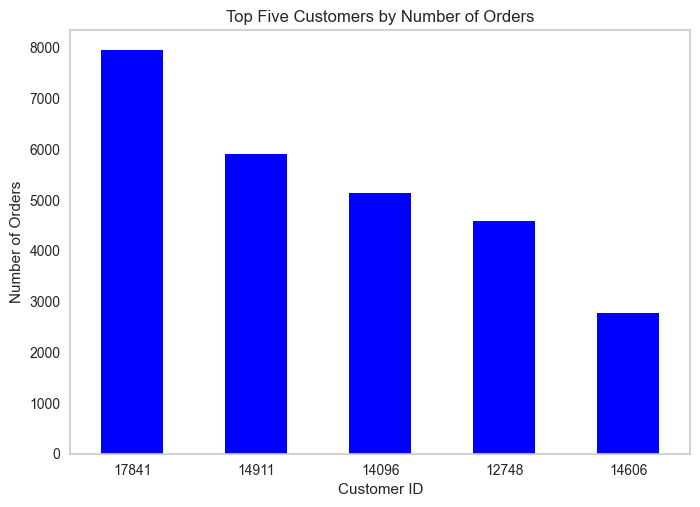

In [35]:
#Visualization
plt.figure(figsize=(10, 6))
top_five_customers.plot(kind='bar', color= ['blue'], legend=False)
plt.title('Top Five Customers by Number of Orders')
plt.xlabel('Customer ID')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.grid(False)
plt.show()

In [36]:
# calculating total price
df1["TotalPrice"] = df1["Quantity"]*df1["UnitPrice"]

C:\Users\rushi\AppData\Local\Temp\ipykernel_22228\2162493996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["TotalPrice"] = df1["Quantity"]*df1["UnitPrice"]


<Axes: ylabel='TotalPrice'>

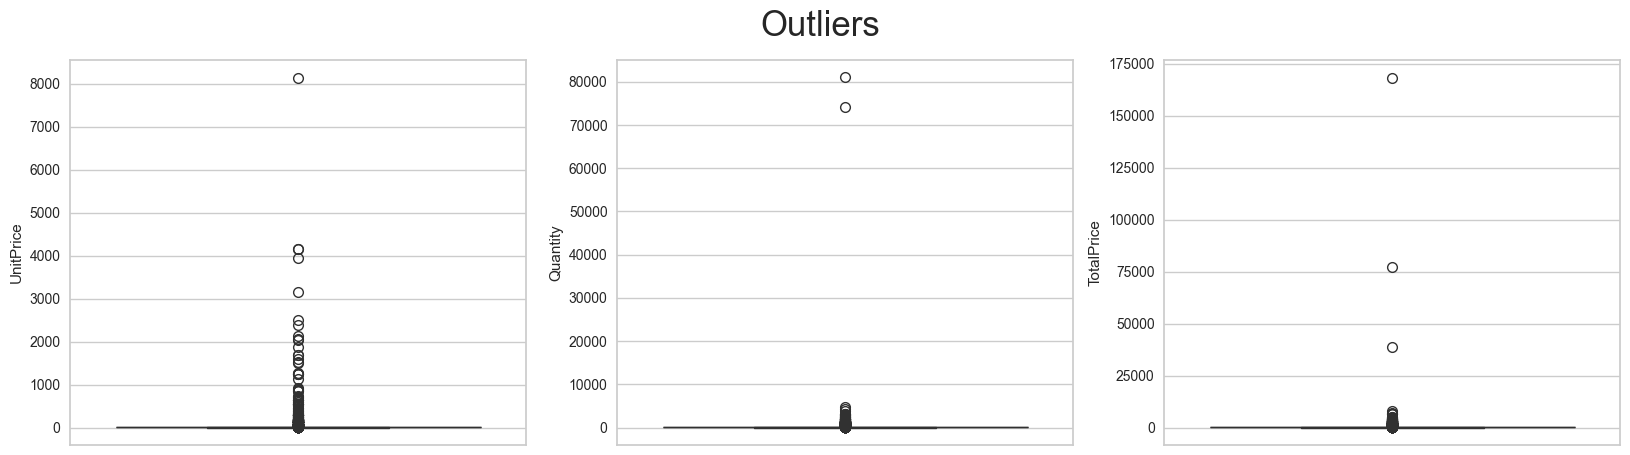

In [37]:
# Checking outliers for unit price , quantity , Total Price
c

In [38]:
df1.shape

(396476, 15)

In [39]:
# managing outliers using Z-score
from scipy.stats import zscore
df1 = df1[(np.abs(zscore(df1[["TotalPrice"]])) < 3).all(axis=1)]

<Axes: ylabel='TotalPrice'>

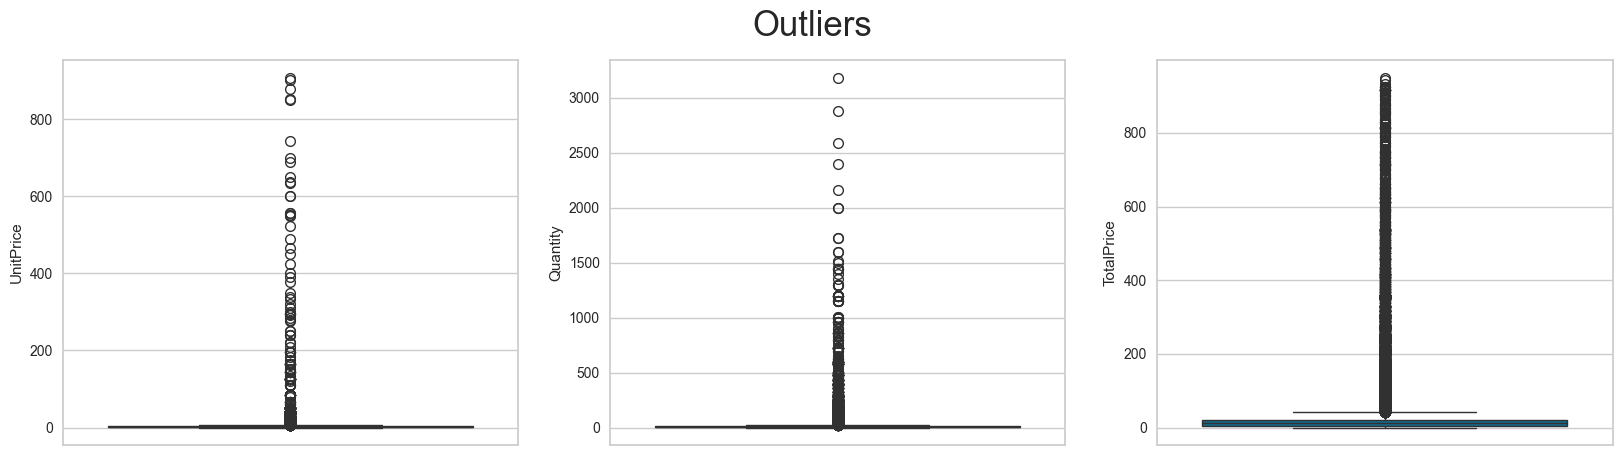

In [40]:
# Checking outliers after normalization
fig = plt.figure(figsize = (20,5))
fig.suptitle("Outliers",size=25)

axes = fig.add_subplot(1, 3, 1)
sns.boxplot(data=df1,y="UnitPrice")

axes = fig.add_subplot(1, 3, 2)
sns.boxplot(data=df1,y="Quantity")

axes = fig.add_subplot(1, 3, 3)
sns.boxplot(data=df1,y="TotalPrice")

In [41]:
df1.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,PaymentMethod,Date,Year,Month,Day,status,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,Credit Card,2010-12-01 08:26:00,2010,12,1,Placed,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,Debit Card,2010-12-01 08:26:00,2010,12,1,Placed,20.34


In [42]:
#RFM Analysis
#Recency
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])
df1['InvoiceDate'].isnull().sum()
df_Recency = df1.dropna(subset=['InvoiceDate'])
df_recency =df_Recency.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
recent_date = df_recency['InvoiceDate'].max()
df_recency['Recency'] = (recent_date - df_recency['InvoiceDate']).dt.days
print(f'Recent Date:{recent_date}')
print(df_recency.shape)
df_recency.head(5)

Recent Date:2011-12-09 12:50:00
(4333, 3)


,CustomerID,InvoiceDate,Recency
0,12347,2011-12-07 15:52:00,1
1,12348,2011-09-25 13:13:00,74
2,12349,2011-11-21 09:51:00,18
3,12350,2011-02-02 16:01:00,309
4,12352,2011-11-03 14:37:00,35


In [43]:
#Frequency
frequency_df = df1.groupby(['CustomerID'])['InvoiceDate'].count().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']
print(frequency_df.shape)
frequency_df.head(5)

(4333, 2)


,CustomerID,Frequency
0,12347,182
1,12348,31
2,12349,73
3,12350,17
4,12352,85


In [44]:
#Monetary
monetary_df = df1.groupby(by='CustomerID', as_index=False)['TotalPrice'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
print(monetary_df.shape)
monetary_df.head(5)

(4333, 2)


,CustomerID,Monetary
0,12347,4310.00
1,12348,1797.24
2,12349,1757.55
3,12350,334.40
4,12352,2506.04


In [45]:
#Merge RFM
rf_df = df_recency.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(monetary_df, on='CustomerID').drop(columns='InvoiceDate')
print(rfm_df.shape)
rfm_df.head(5)

(4333, 4)


,CustomerID,Recency,Frequency,Monetary
0,12347,1,182,4310.00
1,12348,74,31,1797.24
2,12349,18,73,1757.55
3,12350,309,17,334.40
4,12352,35,85,2506.04


In [46]:
# RFM using quartile 
rfm = rfm_df[['CustomerID','Frequency','Recency','Monetary']]
quartiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.5, 0.75])
def assign_score(value, metric):
    if value <= quartiles[metric][0.25]:
        return 4
    elif value <= quartiles[metric][0.5]:
        return 3
    elif value <= quartiles[metric][0.75]:
        return 2
    else:
        return 1

# Assign scores to each customer
rfm['RecencyScore'] = rfm['Recency'].apply(assign_score, metric='Recency')
rfm['FrequencyScore'] = rfm['Frequency'].apply(assign_score, metric='Frequency')
rfm['MonetaryScore'] = rfm['Monetary'].apply(assign_score, metric='Monetary')

# Combine scores into a single RFM score
rfm['RFMScore'] = rfm['RecencyScore'] * 100 + rfm['FrequencyScore'] * 10 + rfm['MonetaryScore']

# Display the resulting DataFrame with RFM scores
rfm.head(5)

C:\Users\rushi\AppData\Local\Temp\ipykernel_22228\4153056396.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['RecencyScore'] = rfm['Recency'].apply(assign_score, metric='Recency')
C:\Users\rushi\AppData\Local\Temp\ipykernel_22228\4153056396.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['FrequencyScore'] = rfm['Frequency'].apply(assign_score, metric='Frequency')
C:\Users\rushi\AppData\Local\Temp\ipykernel_22228\4153056396.py:17: SettingWithCopyWarning: 
A value is trying to be set on a co

,CustomerID,Frequency,Recency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
0,12347,182,1,4310.00,4,1,1,411
1,12348,31,74,1797.24,2,3,1,231
2,12349,73,18,1757.55,3,2,1,321
3,12350,17,309,334.40,1,4,3,143
4,12352,85,35,2506.04,3,2,1,321


In [47]:
def cust_segmentation(rfm):
    if(rfm['RFMScore']==411):
        return 'Best Customer'
    elif(rfm['RFMScore']==144):
        return 'Lost Customer'
    elif(rfm['RFMScore']==244):
        return 'Almost Lost Customer'
    elif(rfm['FrequencyScore']==1):
        return 'Loyal Customer'
    elif(rfm['MonetaryScore']==1):
        return 'Big Spending Customer'
    elif(rfm['RecencyScore']==1 and rfm['FrequencyScore']==4):
        return 'Visitor Customer'  

rfm['Customer Segment'] = rfm.apply(cust_segmentation, axis=1)
rfm.head(5)

C:\Users\rushi\AppData\Local\Temp\ipykernel_22228\3997872378.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['Customer Segment'] = rfm.apply(cust_segmentation, axis=1)


,CustomerID,Frequency,Recency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,Customer Segment
0,12347,182,1,4310.00,4,1,1,411,Best Customer
1,12348,31,74,1797.24,2,3,1,231,Big Spending Customer
2,12349,73,18,1757.55,3,2,1,321,Big Spending Customer
3,12350,17,309,334.40,1,4,3,143,Visitor Customer
4,12352,85,35,2506.04,3,2,1,321,Big Spending Customer


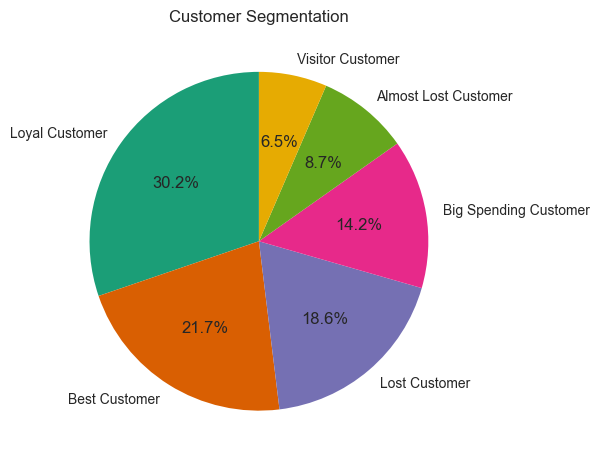

In [48]:
#Customer Segmentation Visualization
segment_counts = rfm['Customer Segment'].value_counts()
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90,colors= sns.color_palette("Dark2"))
plt.title('Customer Segmentation')
plt.show()

           Frequency  Monetary   Recency
Frequency   1.000000  0.531295 -0.206430
Monetary    0.531295  1.000000 -0.150153
Recency    -0.206430 -0.150153  1.000000


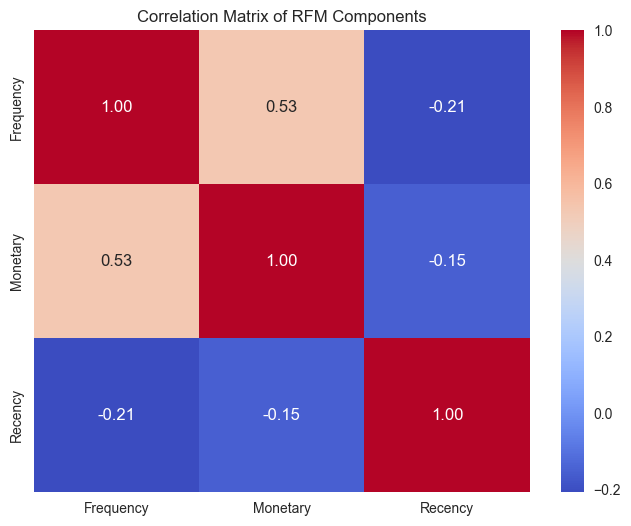

In [49]:
# correlation between frequency , recency and monetary
cor_matrix = rfm_df[['Frequency','Monetary','Recency']].corr()
print(cor_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of RFM Components')
plt.show()

In [50]:
#Creating 2 dataframes for clustering
df_fm = rfm_df[['Frequency','Monetary']]
df_rm = rfm_df[['Recency','Monetary']]

In [51]:
df_fm.shape

(4333, 2)

<Axes: ylabel='Monetary'>

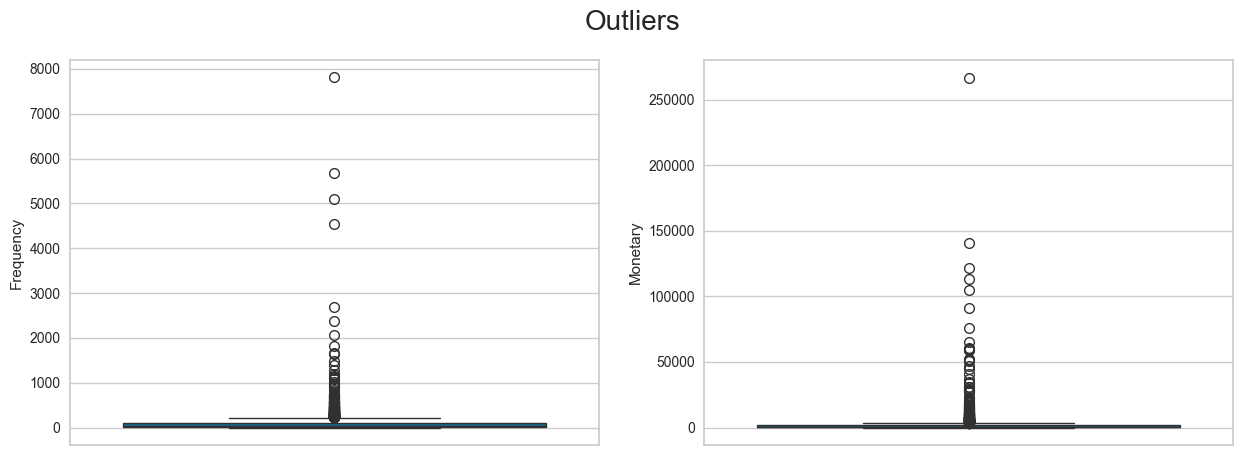

In [52]:
# Outlier Before Normalization (df_fm) - Visualization
fig = plt.figure(figsize = (15,5))
fig.suptitle("Outliers",size=20)

axes = fig.add_subplot(1, 2, 1)
sns.boxplot(data=df_fm,y="Frequency")

axes = fig.add_subplot(1, 2, 2)
sns.boxplot(data=df_fm,y="Monetary")

In [53]:
# z-score normalization for df_fm
df_fm = df_fm[(np.abs(zscore(df_fm[["Monetary"]])) < 3).all(axis=1)]
df_fm = df_fm[(np.abs(zscore(df_fm[["Frequency"]])) < 3).all(axis=1)]

<Axes: ylabel='Monetary'>

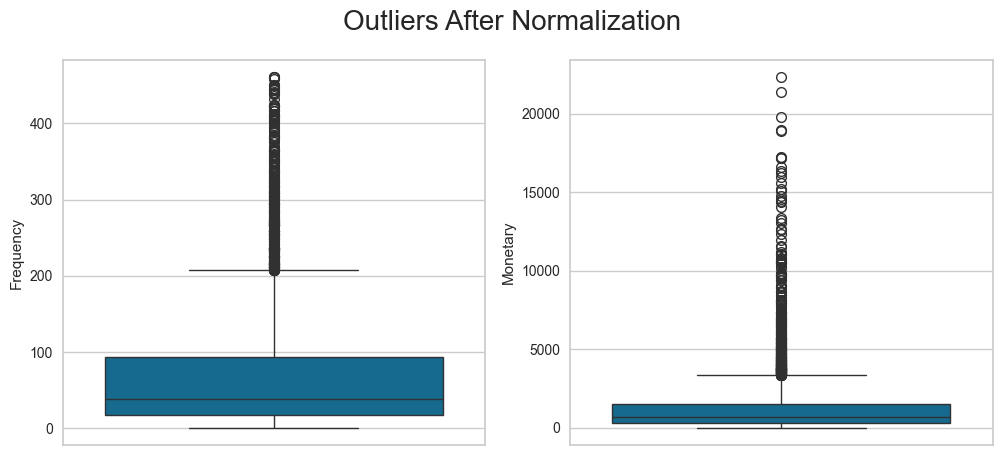

In [54]:
# Outliers After Normalization - Visualization
fig = plt.figure(figsize = (12,5))
fig.suptitle("Outliers After Normalization",size=20)

axes = fig.add_subplot(1, 2, 1)
sns.boxplot(data=df_fm,y="Frequency")

axes = fig.add_subplot(1, 2, 2)
sns.boxplot(data=df_fm,y="Monetary")

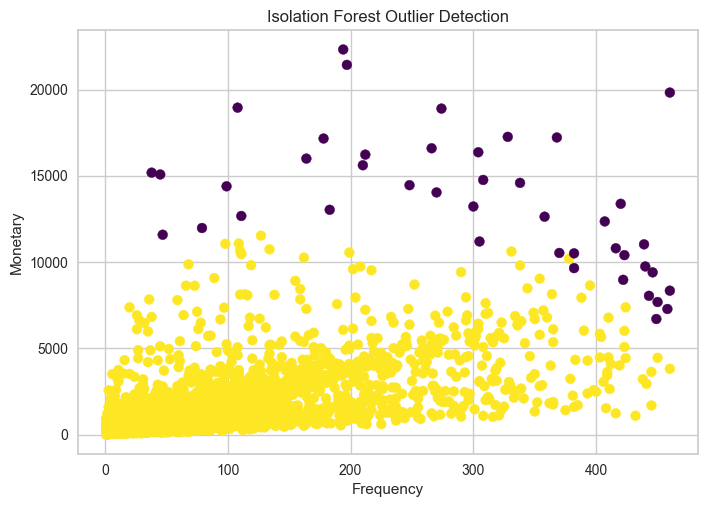

,Frequency,Monetary,Outlier
0,182,4310.00,1
1,31,1797.24,1
2,73,1757.55,1
3,17,334.40,1
4,85,2506.04,1


In [55]:
# Isolation forest to remove anamolies (df_fm)
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.01)  # Contamination is the expected proportion of outliers
isolation_forest.fit(df_fm)

df_fm['Outlier'] = isolation_forest.predict(df_fm)  #(1 for inliers, -1 for outliers)

plt.scatter(df_fm['Frequency'], df_fm['Monetary'], c=df_fm['Outlier'], cmap='viridis', s=50)
plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()
df_fm.head(5)

In [56]:
# removing anamolies from datafrmae using isolation forest
df_fm = df_fm[df_fm['Outlier']==1]

C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

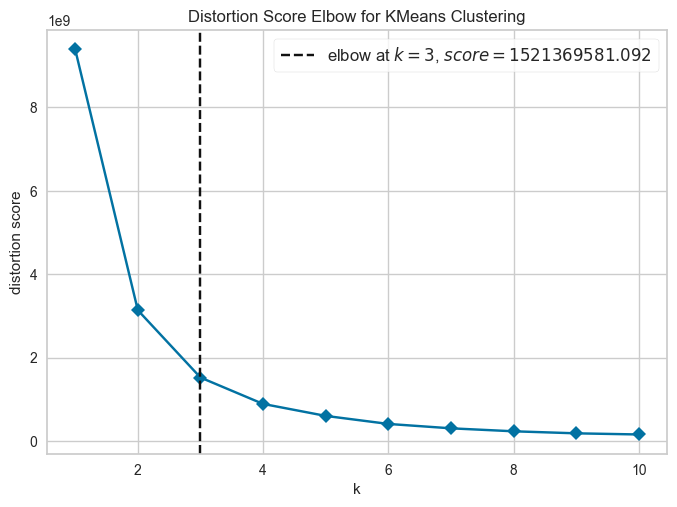

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:
# Elbow method for number of clusters
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_fm)        
visualizer.show()        

C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


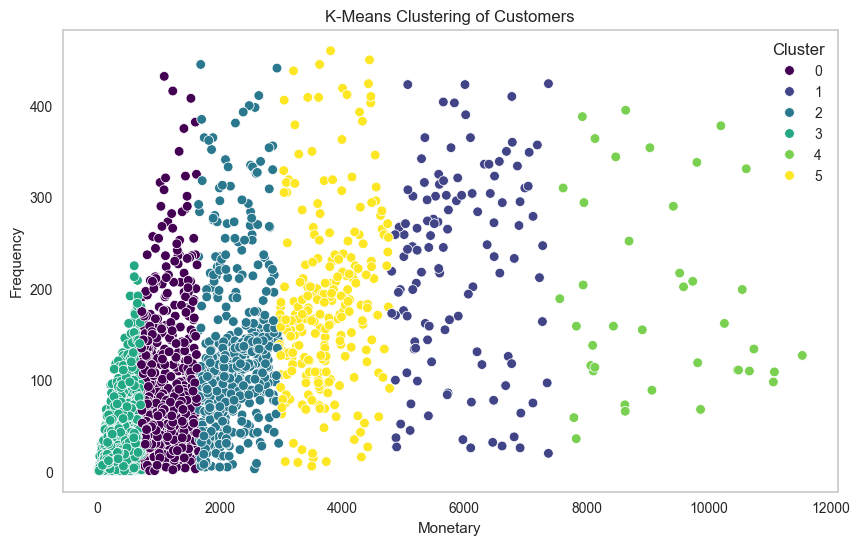

In [58]:
# Kmean clustering Visualization (df_fm)
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters,max_iter = 1000)
df_fm['Cluster'] = kmeans.fit_predict(df_fm)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Monetary', y='Frequency', hue='Cluster', data=df_fm, palette='viridis')
plt.title('K-Means Clustering of Customers')
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

<Axes: ylabel='Monetary'>

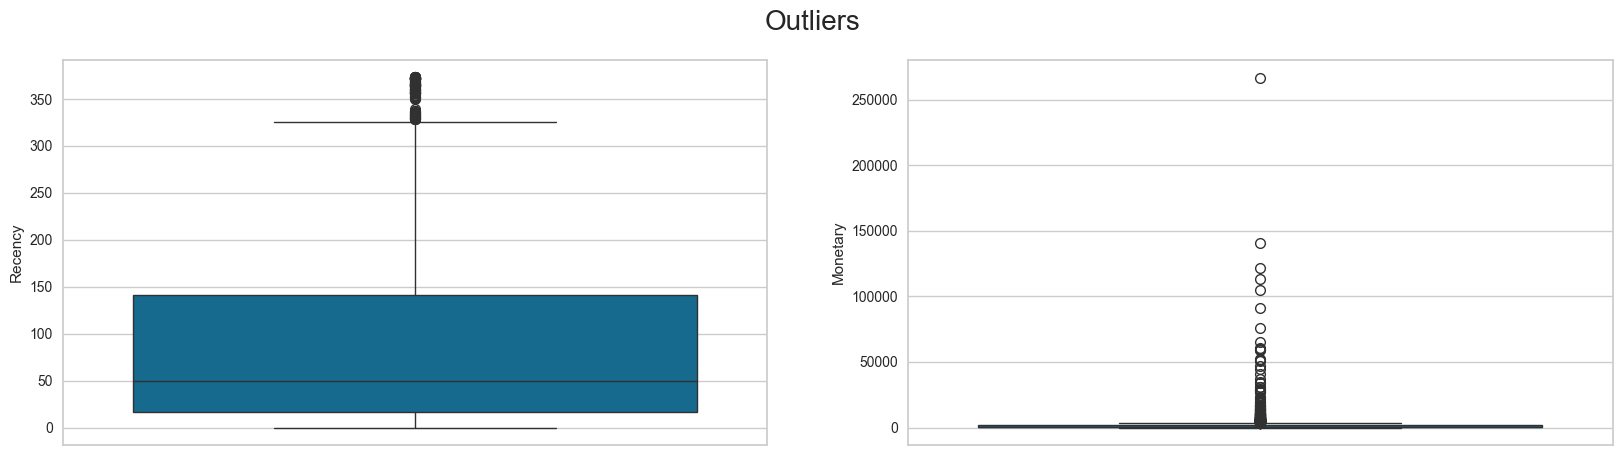

In [59]:
# Outlier Before Normalization (df_rm) - Visualization
fig = plt.figure(figsize = (20,5))
fig.suptitle("Outliers",size=20)

axes = fig.add_subplot(1, 2, 1)
sns.boxplot(data=df_rm,y="Recency")

axes = fig.add_subplot(1, 2, 2)
sns.boxplot(data=df_rm,y="Monetary")

In [60]:
# z-score normalization on df_rm
df_rm = df_rm[(np.abs(zscore(df_rm[["Monetary"]])) < 3).all(axis=1)]
df_rm = df_rm[(np.abs(zscore(df_rm[["Recency"]])) < 3).all(axis=1)]

<Axes: ylabel='Monetary'>

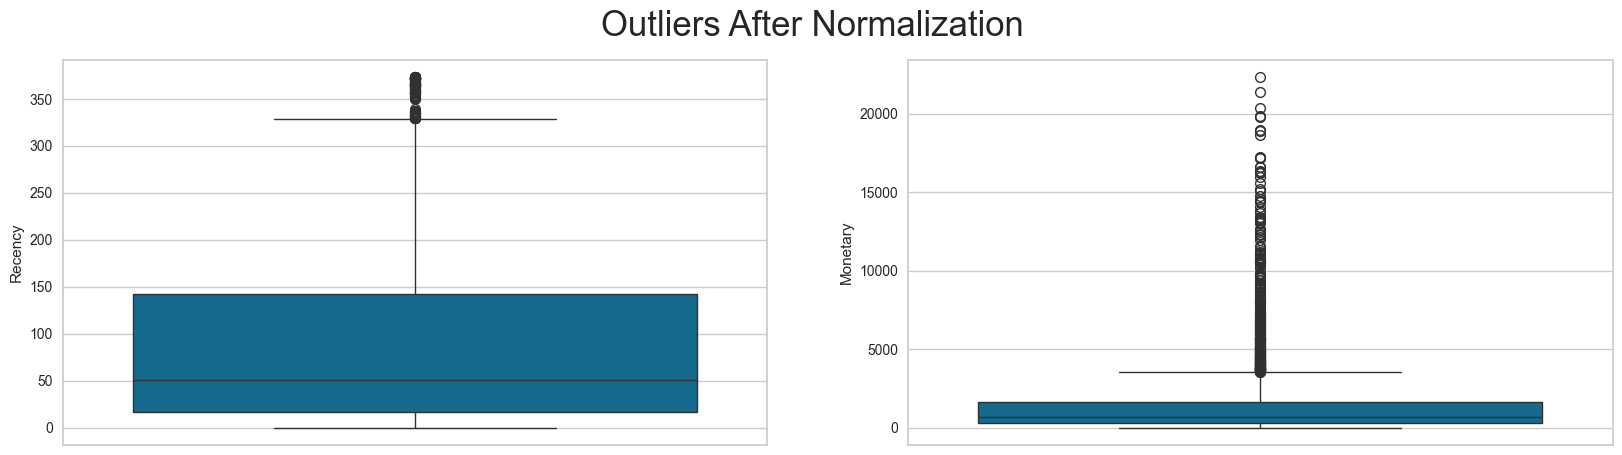

In [61]:
# Outlier After Normalization (df_rm) - Visualization
fig = plt.figure(figsize = (20,5))
fig.suptitle("Outliers After Normalization",size=25)

axes = fig.add_subplot(1, 2, 1)
sns.boxplot(data=df_rm,y="Recency")

axes = fig.add_subplot(1, 2, 2)
sns.boxplot(data=df_rm,y="Monetary")

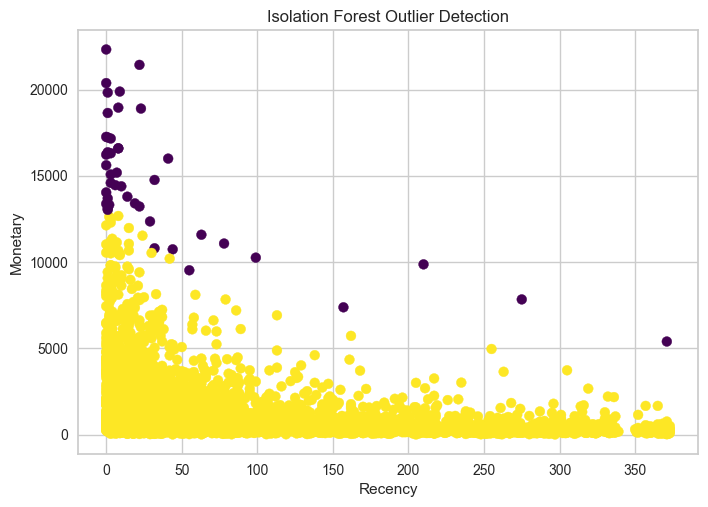

,Recency,Monetary,Outlier
0,1,4310.00,1
1,74,1797.24,1
2,18,1757.55,1
3,309,334.40,1
4,35,2506.04,1


In [62]:
# Isolation forest to remove anamolies - df_rm
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.01)  # Contamination is the expected proportion of outliers
isolation_forest.fit(df_rm)

# Predict outliers (1 for inliers, -1 for outliers)
df_rm['Outlier'] = isolation_forest.predict(df_rm)

plt.scatter(df_rm['Recency'], df_rm['Monetary'], c=df_rm['Outlier'], cmap='viridis', s=50)
plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()
df_rm.head(5)

In [63]:
# removing anamolies from datafrmae isolation forest
df_rm = df_rm[df_rm['Outlier']==1]

C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

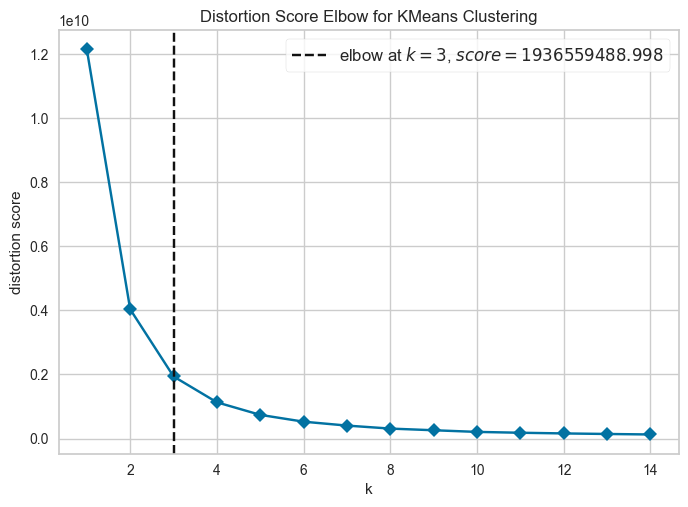

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [64]:
# elbow method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15), timings= False)
visualizer.fit(df_rm)        
visualizer.show()        

C:\Users\rushi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


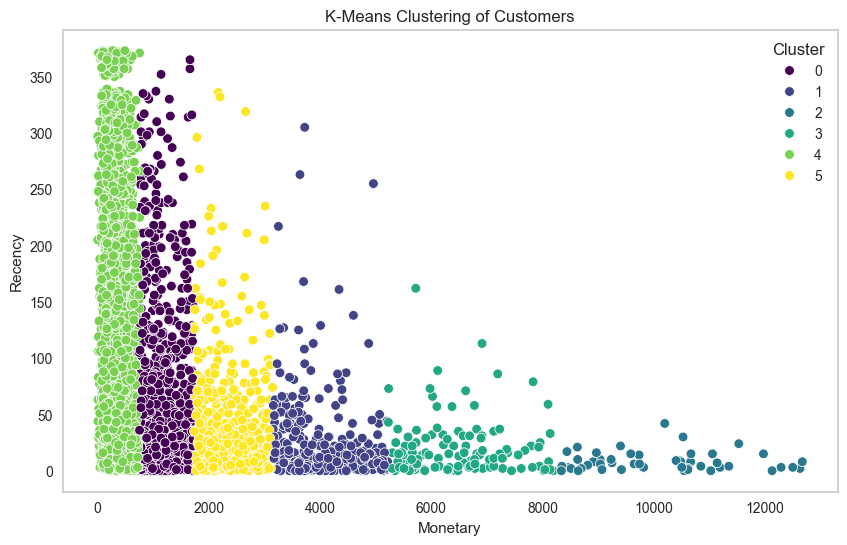

In [65]:
#KMean - df_rm
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42 , max_iter = 100)
df_rm['Cluster'] = kmeans.fit_predict(df_rm)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Monetary', y='Recency', hue='Cluster', data=df_rm, palette='viridis')
plt.title('K-Means Clustering of Customers')
plt.xlabel('Monetary')
plt.ylabel('Recency')
plt.grid(False)
plt.show()

In [66]:
# Correlation between frequency and monetary
plt.figure(figsize=(6,6))
cor_matrix = df_fm[['Frequency','Monetary']].corr()
cor_matrix

,Frequency,Monetary
Frequency,1.000000,0.662819
Monetary,0.662819,1.000000


<Figure size 600x600 with 0 Axes>

In [67]:
# Correlation between Recency and monetary
cor_matrix = df_rm[['Recency','Monetary']].corr()
cor_matrix

,Recency,Monetary
Recency,1.000000,-0.340998
Monetary,-0.340998,1.000000


### Product Analysis

In [68]:
top_products = df1.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Average price of products in the dataset
average_price = df1['UnitPrice'].mean()

# Product category generating the highest revenue
revenue_by_category = df1.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
highest_revenue_category = revenue_by_category.idxmax()

print(f"Top 10 most frequently purchased products:\n{top_products}")
print(f"\nAverage price of products in the dataset:{round(average_price,2)}")
print(f"\nProduct category generating the highest revenue:{highest_revenue_category}")

Top 10 most frequently purchased products:
Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     49615
JUMBO BAG RED RETROSPOT               42979
POPCORN HOLDER                        39486
PACK OF 72 RETROSPOT CAKE CASES       33685
ASSORTED COLOUR BIRD ORNAMENT         30298
WHITE HANGING HEART T-LIGHT HOLDER    28095
MINI PAINT SET VINTAGE                26076
PACK OF 12 LONDON TISSUES             25343
BROCADE RING PURSE                    22927
VICTORIAN GLASS HANGING T-LIGHT       22433
Name: Quantity, dtype: int64

Average price of products in the dataset:2.99

Product category generating the highest revenue:REGENCY CAKESTAND 3 TIER


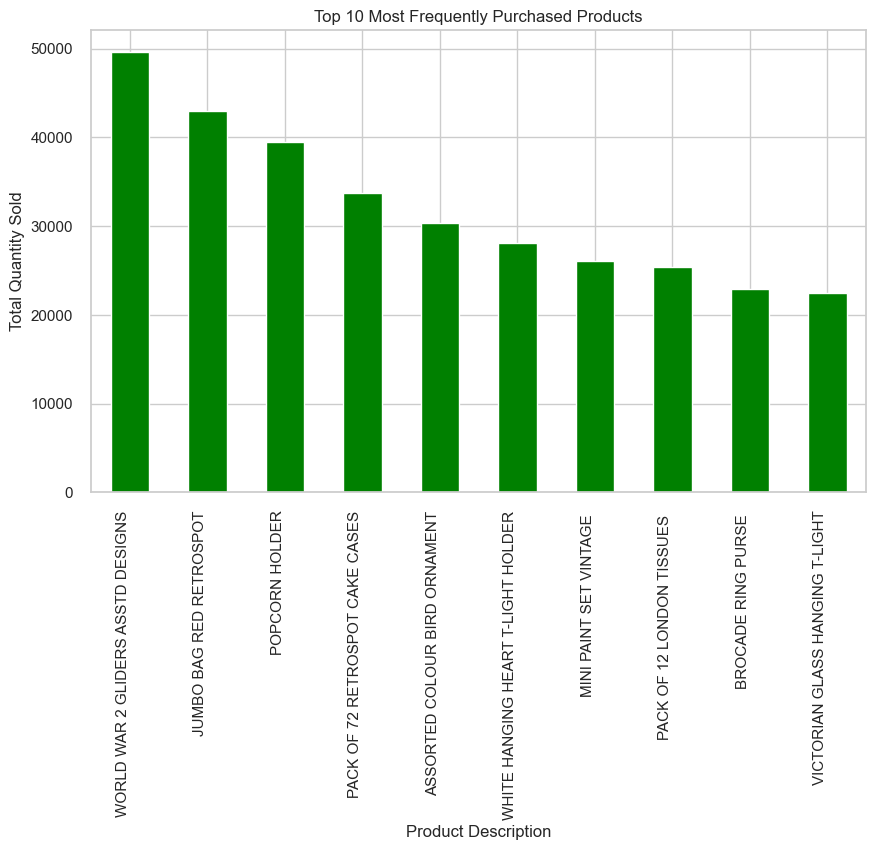

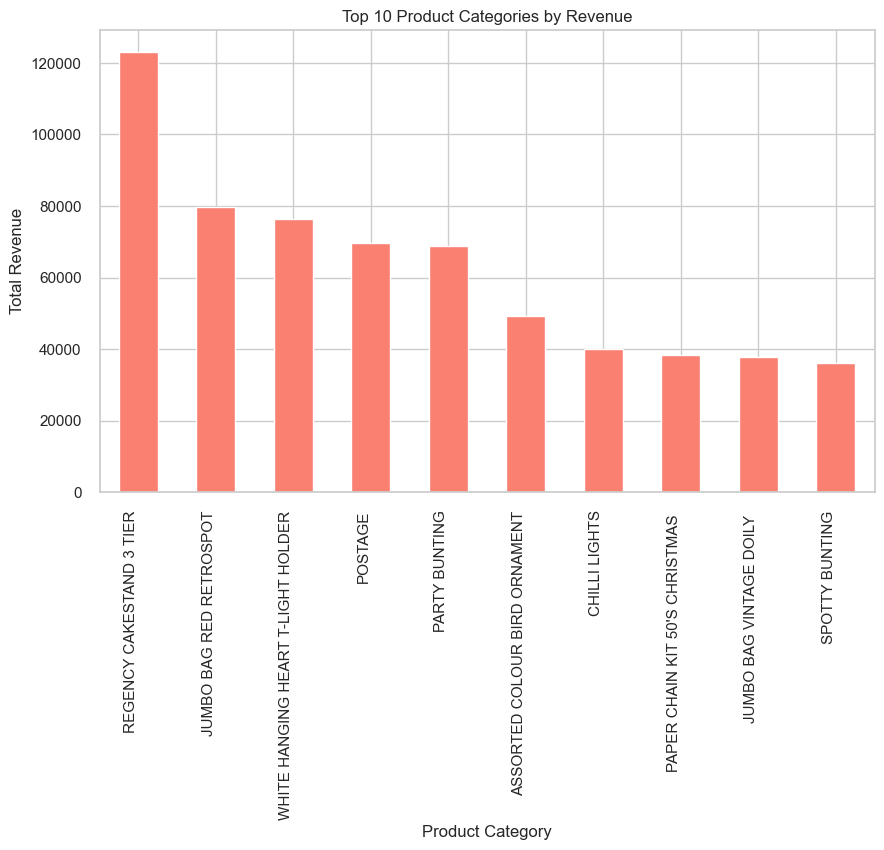

In [69]:
#Visualization 
sns.set(style="whitegrid")

# Visualization for Top 10 most frequently purchased products
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='green')
plt.title('Top 10 Most Frequently Purchased Products')
plt.xlabel('Product Description')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90, ha='right')
plt.show()

# Visualization for Product category generating the highest revenue
plt.figure(figsize=(10, 6))
revenue_by_category.head(10).plot(kind='bar', color='salmon')
plt.title('Top 10 Product Categories by Revenue')
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=90, ha='right')
plt.show()

### Time Analysis

In [70]:
df1['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df1['DayOfWeek'] = df1['InvoiceDate'].dt.day_name()
df1['HourOfDay'] = df1['InvoiceDate'].dt.hour

most_orders_day = df1['DayOfWeek'].value_counts().idxmax()
most_orders_hour = df1['HourOfDay'].value_counts().idxmax()
most_orders_month = df1['InvoiceDate'].dt.month_name().value_counts().idxmax()

monthly_order_trends = df1.resample('M', on='InvoiceDate').size()
print("Day of the week with most orders:", most_orders_day)
print("Hour of the day with most orders:", most_orders_hour)
print("Month with most orders:", most_orders_month)

Day of the week with most orders: Thursday
Hour of the day with most orders: 12
Month with most orders: November


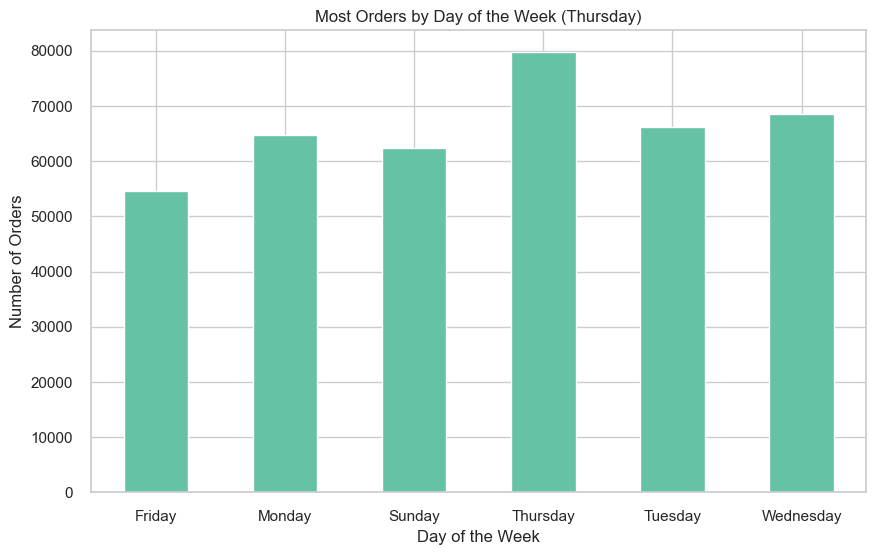

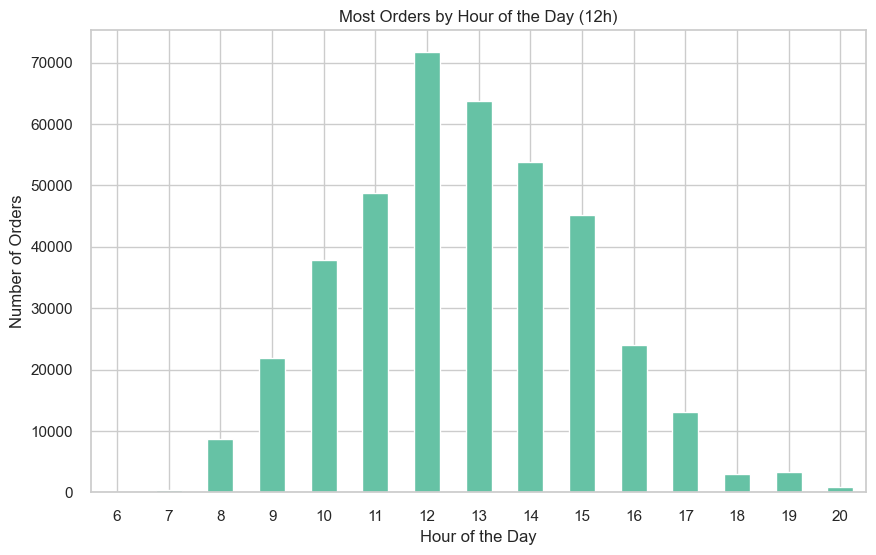

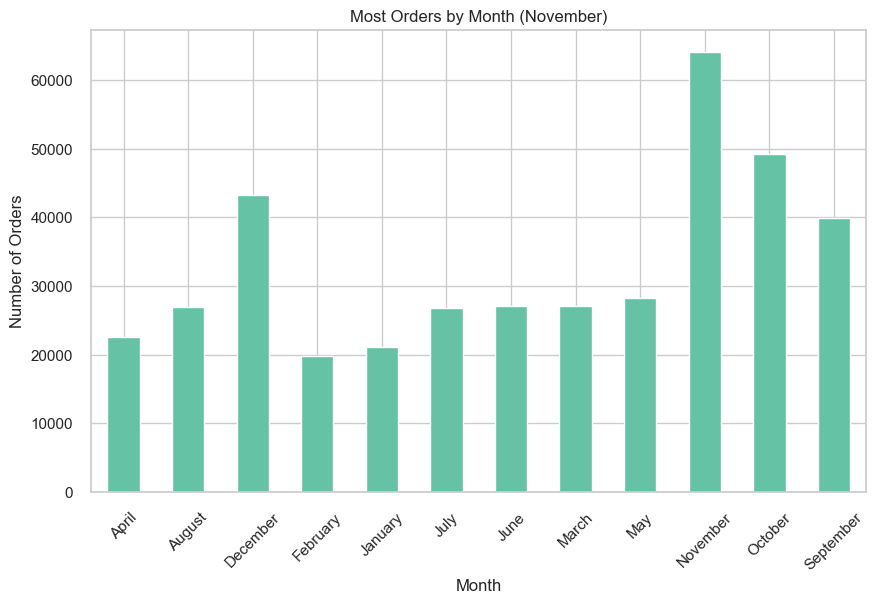

In [71]:
# Visualization Q4
sns.set_palette("Set2")

plt.figure(figsize=(10, 6))
df1['DayOfWeek'].value_counts().sort_index().plot(kind='bar')
plt.title(f'Most Orders by Day of the Week ({most_orders_day})')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 6))
df1['HourOfDay'].value_counts().sort_index().plot(kind='bar')
plt.title(f'Most Orders by Hour of the Day ({most_orders_hour}h)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 6))
df1['InvoiceDate'].dt.month_name().value_counts().sort_index().plot(kind='bar')
plt.title(f'Most Orders by Month ({most_orders_month})')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

### Geographical Analysis



Top 5 countries with the highest number of orders:
Country
United Kingdom    352637
Germany             9038
France              8337
EIRE                7222
Spain               2478
Name: count, dtype: int64


Average order value by country:
                 Country  TotalPrice
0              Australia  108.083612
1                Austria   25.624824
2                Bahrain   32.258824
3                Belgium   20.283772
4                 Brazil   35.737500
5                 Canada   24.280662
6        Channel Islands   27.363507
7                 Cyprus   22.197680
8         Czech Republic   33.069600
9                Denmark   49.882474
10                  EIRE   34.611459
11    European Community   21.670833
12               Finland   32.913985
13                France   23.741532
14               Germany   25.320772
15                Greece   32.831172
16               Iceland   23.681319
17                Israel   29.230931
18                 Italy   23.064960
19            

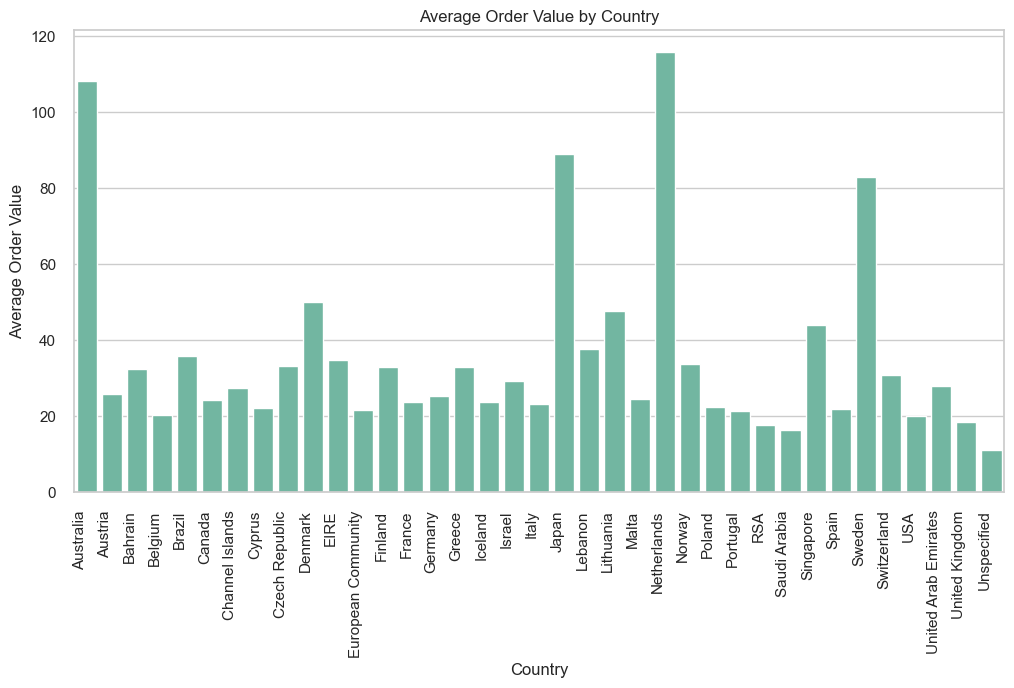

In [73]:
top_countries = df1['Country'].value_counts().head(5)

average_order_value_by_country = df1.groupby('Country')['TotalPrice'].mean()
average_order_value_by_country.rename({'TotalPrice': 'AverageValue'}, inplace=True)

print(f"\n\nTop 5 countries with the highest number of orders:\n{top_countries}")
print(f"\n\nAverage order value by country:\n{average_order_value_by_country.reset_index()}\n\n")


plt.figure(figsize=(12, 6))
sns.barplot(x=average_order_value_by_country.index, y=average_order_value_by_country.values)
plt.title("Average Order Value by Country")
plt.xlabel("Country")
plt.ylabel("Average Order Value")
plt.xticks(rotation=90, ha='right')
plt.show()

### Payment Analysis
###### Note: Payment analysis are done on dummy data

Most Common Payment Methods:
PaymentMethod
Credit Card      157985
Debit Card        79501
Cash              67625
PayPal            59321
Bank Transfer     19732
EMI               11969
Name: count, dtype: int64


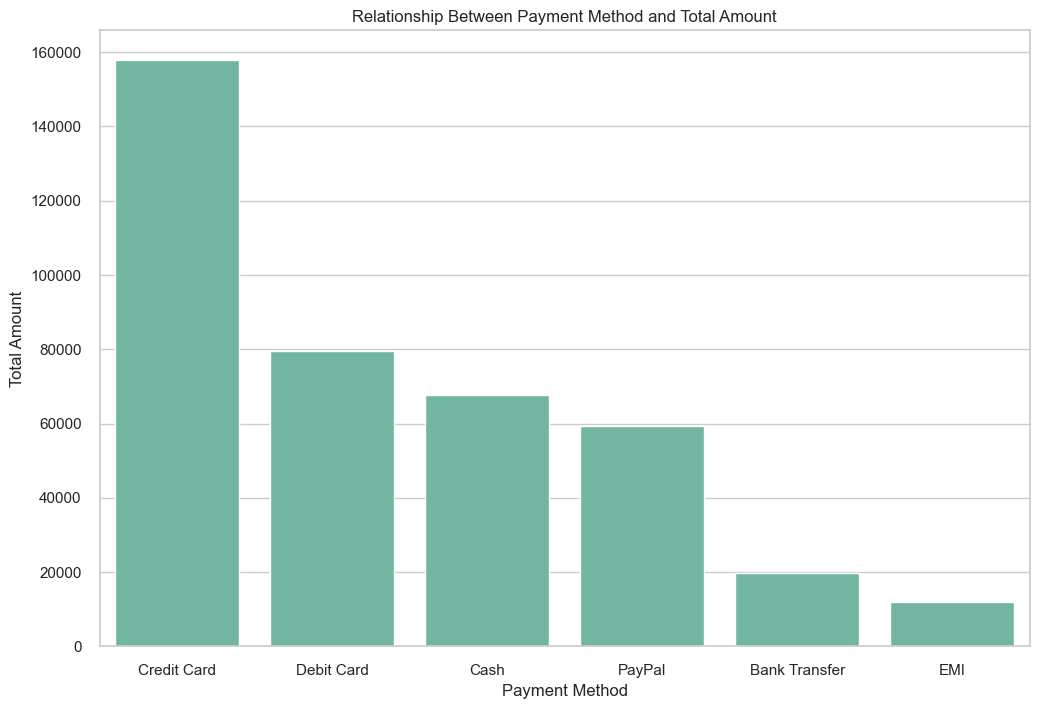

In [74]:
common_payment_methods = df1['PaymentMethod'].value_counts()
print(f"Most Common Payment Methods:\n{common_payment_methods}")
common_payment_methods = common_payment_methods.reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='PaymentMethod', y='count', data=common_payment_methods)
plt.title('Relationship Between Payment Method and Total Amount')
plt.xlabel('Payment Method')
plt.ylabel('Total Amount')
plt.show()

### Customer Behaviour

Maximum Duration between two Purchases: 373
Minimum Duration between two Purchases: 0
Average Customer Lifespan: 133.42 days


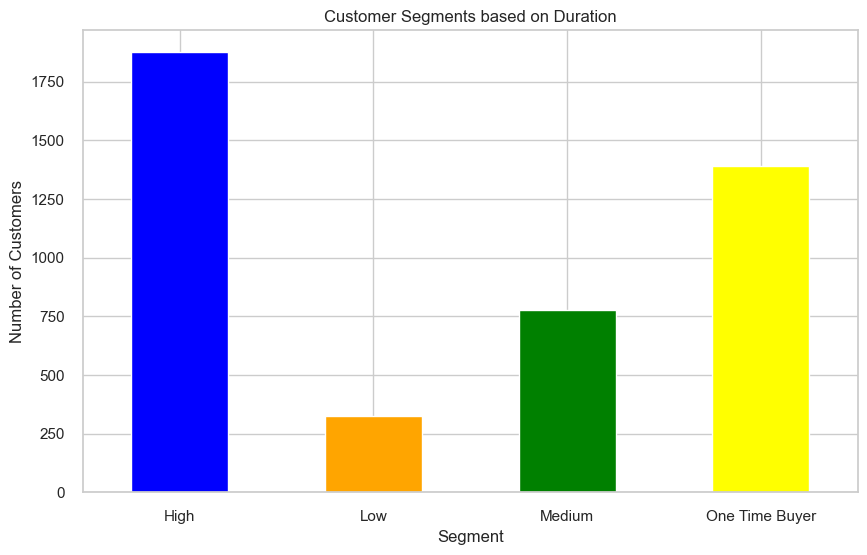

In [76]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
customer_duration = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_duration['Duration'] = (customer_duration['max'] - customer_duration['min']).dt.days

average_duration = customer_duration['Duration'].mean()
x = customer_duration['Duration'].max()
y = customer_duration['Duration'].min()
print(f"Maximum Duration between two Purchases: {x}\nMinimum Duration between two Purchases: {y}")
print(f"Average Customer Lifespan: {average_duration:.2f} days")

def customer_seg(duration):
    if duration == 0:
        return 'One Time Buyer'
    elif 0 < duration <= 30:
        return 'Low'
    elif 30 < duration <= 150:
        return 'Medium'
    else:
        return 'High'

customer_duration['DurationSegment'] = customer_duration['Duration'].apply(customer_seg)
plt.figure(figsize=(10, 6)) 
customer_duration['DurationSegment'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange', 'green','yellow'])
plt.title('Customer Segments based on Duration')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()

### Return and refund
###### Note : As there is not data available for return and refund . We are assumping cancellled orders as returned orders

In [78]:
total_orders = df.shape[0]
print(f'Total number of orders:{total_orders}')
orders_with_returns = df[df['status'].isin(['Cancelled'])].shape[0]
print(f'Number of orders makred as cancelled/return:{orders_with_returns}')
percentage_returns_refunds = (orders_with_returns / total_orders) * 100
print(f"Percentage of Orders with Returns or Refunds: {percentage_returns_refunds:.2f}%")

Total number of orders:537967
Number of orders makred as cancelled/return:9277
Percentage of Orders with Returns or Refunds: 1.72%


In [79]:
# contingency table to check number of placed and cancelled orders per customer 
contingency_table = pd.crosstab(df['Description'], df['status'], margins=True)
contingency_table_sorted = contingency_table.sort_values(by='Cancelled', ascending=False)
contingency_table_sorted.drop('All',axis=1)
contingency_table_sorted.head(5)

status,Cancelled,Placed,All
Description,,,
All,9277,528690,537967
Manual,244,319,563
REGENCY CAKESTAND 3 TIER,181,2016,2197
POSTAGE,126,1126,1252
JAM MAKING SET WITH JARS,87,1136,1223


In [80]:
contingency_table = pd.crosstab(df['Description'], df['status'], margins=True)
cancelled_counts = contingency_table['Cancelled']
cancelled_counts = cancelled_counts[:-1]
top_10_cancelled_products = cancelled_counts.sort_values(ascending=False).head(10)
print(f"Top 10 Most Returned/Cancelled Products:\n{top_10_cancelled_products}")

Top 10 Most Returned/Cancelled Products:
Description
Manual                               244
REGENCY CAKESTAND 3 TIER             181
POSTAGE                              126
JAM MAKING SET WITH JARS              87
Discount                              77
SET OF 3 CAKE TINS PANTRY DESIGN      73
SAMPLES                               61
STRAWBERRY CERAMIC TRINKET BOX        61
ROSES REGENCY TEACUP AND SAUCER       54
POPCORN HOLDER                        50
Name: Cancelled, dtype: int64


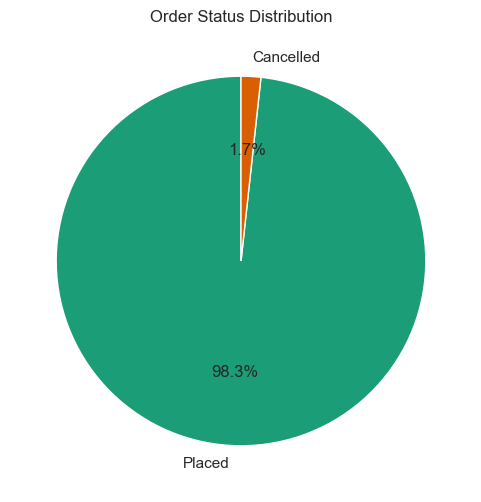

In [81]:
# cancelled vs placed pie chart 
order_status_distribution = df['status'].value_counts()
sns.set_palette("Dark2")
plt.figure(figsize=(6, 6))
plt.pie(order_status_distribution, labels=order_status_distribution.index, autopct='%1.1f%%', startangle=90)
plt.title('Order Status Distribution')
plt.show()

### Country wise Analysis 

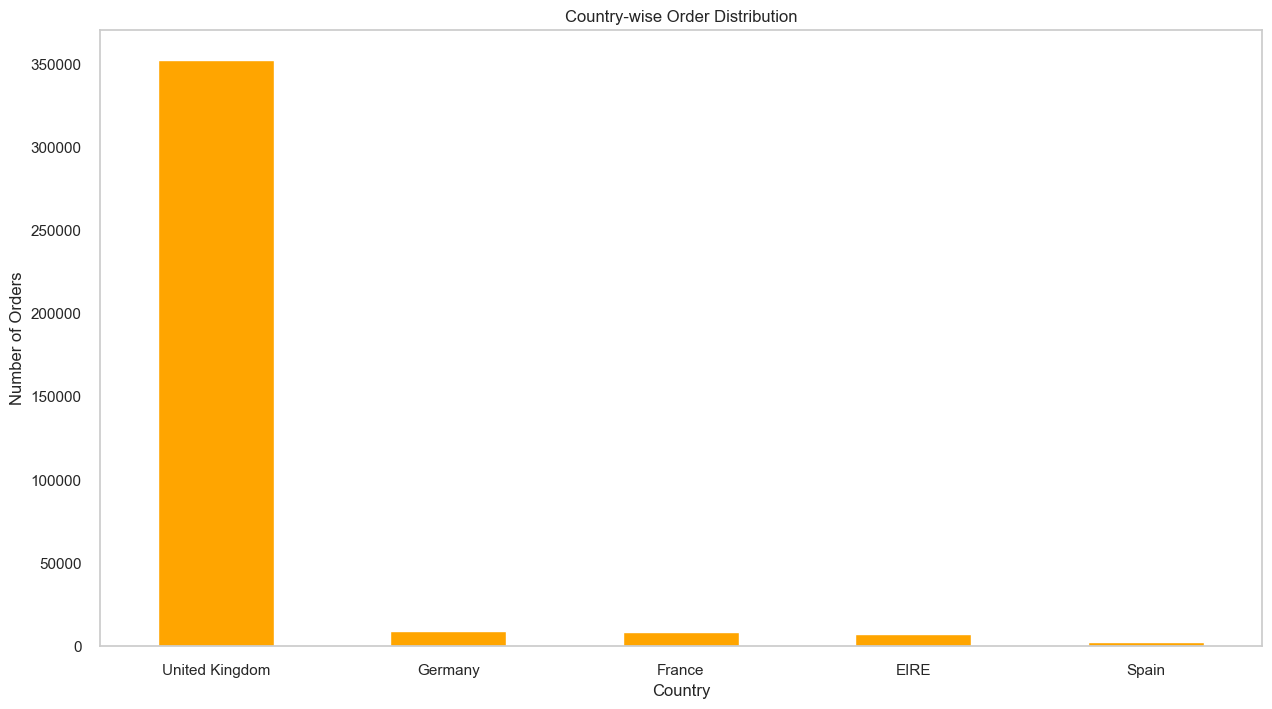

In [82]:
country_order_distribution = df1['Country'].value_counts().head(5)
sns.set_palette("Dark2")
plt.figure(figsize=(15, 8))
country_order_distribution.plot(kind='bar',color = 'Orange')  # Use country_order_distribution instead of country_order_distribution_filtered
plt.title('Country-wise Order Distribution')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0, ha='center')
plt.grid(False)
plt.show()

### Customer Satisfaction

##### The data on customer feedback or ratings for products or services is not available, it's not possible to  draw conclusions related to customer feedback or ratings. 